In [3]:
%matplotlib widget

#### Worldwide inflation as Gaussian Process - timeseries analysis
In this book, I try to model inflation in various major economies (US, EU, UK, CA, AU, NZ, JP) as a Gaussian Process.
Gaussian Process (which is a distribution over functions) is easily available in libraries as a single output function of possibly multiple inputs, but not as a multi-output (although they exist): I use therefore as inputs essentially time and a "integer flag" that indicates which variable I am observing, and a single output, i.e. the value of inflation.
I could also include other - maybe global - inputs in theory, like FX rates against USD, but it's more complicated to get all data in a consistent manner (e.g. you should use a sensible choice for FX) and projections become trickier by definition as you need to include how that input evolves over time going forward.
To summarise, I try to see how a Gaussian Process on time would work for inflation: I basically try to predict inflation on the basis of past inflation itself and how that changes over time, which can be loosely translated into a prior on the shape of the function. 
Each time a datapoint comes in, the function will get "more defined" in the vicinity of the datapoint and could change of course significantly. 
The advantages of Gaussian Processes is that they inherently allow to provide a **confidence level**.

In [4]:
# let's get data... let's use FRED
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from fredapi import Fred as FredApi

fred = FredApi(api_key='0dfcbb403eea7fee006f01e935be9216')
cpi_us = fred.get_series_latest_release('CPIAUCSL')
cpi_eu = fred.get_series_latest_release('CP0000EZ19M086NEST')
# OECD data below... may not be aligned on the latest available and some are even quarterly
cpi_uk = fred.get_series_latest_release('GBRCPIALLMINMEI')
cpi_ca = fred.get_series_latest_release('CANCPIALLMINMEI')
cpi_au = fred.get_series_latest_release('AUSCPIALLQINMEI')
cpi_nz = fred.get_series_latest_release('NZLCPIALLQINMEI')
cpi_jp = fred.get_series_latest_release('JPNCPIALLMINMEI')

index = cpi_us.index
cpi_us.name = 'US'
cpi_eu = cpi_eu.reindex_like(cpi_us)
cpi_eu.name = 'EU'
cpi_uk = cpi_uk.reindex_like(cpi_us)
cpi_uk.name = 'UK'
cpi_ca = cpi_ca.reindex_like(cpi_us)
cpi_ca.name = 'CA'
cpi_au = cpi_au.reindex_like(cpi_us).shift(-1)
cpi_au.name = 'AU'
cpi_nz = cpi_nz.reindex_like(cpi_us).shift(-1)
cpi_nz.name = 'NZ'
cpi_jp = cpi_jp.reindex_like(cpi_us)
cpi_jp.name = 'JP'

In [5]:
cpi_all = pd.concat([cpi_us, cpi_eu, cpi_uk, cpi_ca, cpi_au, cpi_nz, cpi_jp], axis=1).resample('M').last()
cpi_all_yoy = cpi_all.pct_change(periods=12, fill_method=None)*100
cpi_all_yoy.tail()

,US,EU,UK,CA,AU,NZ,JP
2021-11-30,6.828372,4.866412,4.582951,4.720407,NaN,NaN,0.603015
2021-12-31,7.096542,4.964337,4.844607,4.803493,NaN,NaN,0.805639
2022-01-31,7.525934,5.108242,4.849039,5.137482,NaN,NaN,0.501002
2022-02-28,7.912024,5.874550,5.484461,5.687545,NaN,NaN,0.901804
2022-03-31,8.557586,7.443913,NaN,NaN,NaN,NaN,NaN


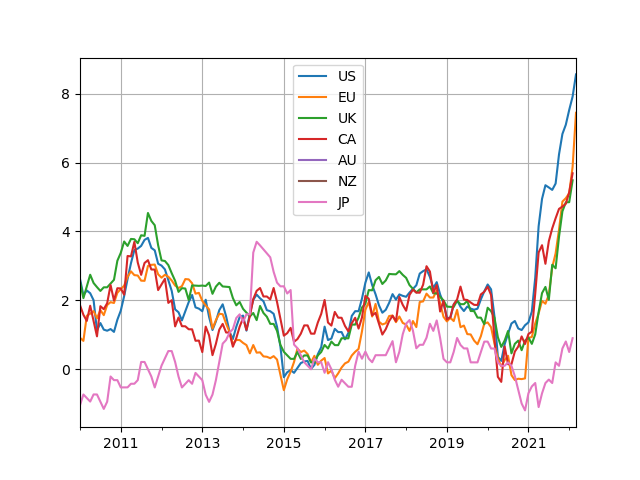

In [6]:
cpi_all_yoy.loc['2010':].plot(grid=True);

Now let's manipulate the dataset and create one big array of X and one for y, where:

- X contains on the first column, time, as years from a baseline, and on the second column an integer flag on the country
- y contains all the samples available

In [7]:
flags = pd.DataFrame(index=cpi_all_yoy.index, columns=cpi_all_yoy.columns, dtype=float)
for i,c in enumerate(cpi_all_yoy.columns):
    flags[c] = i
flags.tail()

,US,EU,UK,CA,AU,NZ,JP
2021-11-30,0,1,2,3,4,5,6
2021-12-31,0,1,2,3,4,5,6
2022-01-31,0,1,2,3,4,5,6
2022-02-28,0,1,2,3,4,5,6
2022-03-31,0,1,2,3,4,5,6


In [24]:
t_base_year = 2000
t = pd.Series(cpi_all_yoy.index.year.to_numpy() + cpi_all_yoy.index.month.to_numpy()/12-t_base_year, index=cpi_all_yoy.index)
all_t = pd.concat([t for _ in flags.columns], axis=1)
all_t.tail()

,0,1,2,3,4,5,6
2021-11-30,21.916667,21.916667,21.916667,21.916667,21.916667,21.916667,21.916667
2021-12-31,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
2022-01-31,22.083333,22.083333,22.083333,22.083333,22.083333,22.083333,22.083333
2022-02-28,22.166667,22.166667,22.166667,22.166667,22.166667,22.166667,22.166667
2022-03-31,22.250000,22.250000,22.250000,22.250000,22.250000,22.250000,22.250000


In [43]:
start_date = '2000'
end_date = '2021-06'
y_df = cpi_all_yoy.loc[start_date:end_date]
y_df.head()

,US,EU,UK,CA,AU,NZ,JP
2000-01-31,2.792957,1.933551,1.114206,2.185792,NaN,NaN,-0.713558
2000-02-29,3.217972,2.024181,1.251739,2.729258,NaN,NaN,-0.614125
2000-03-31,3.762136,2.058226,0.968188,3.043478,3.0837,2.0,-0.511247
2000-04-30,3.013864,1.808123,0.964187,2.162162,NaN,NaN,-0.813835
2000-05-31,3.132530,1.860841,0.961538,2.373247,NaN,NaN,-0.712106


In [10]:
y = y_df.to_numpy().reshape(-1,1).squeeze()
y[-10:]

array([        nan,         nan, -0.6993007 ,  5.34101556,  1.90178825,
        2.38970588,  3.06122449,  3.01204819,  4.93358634, -0.4004004 ])

In [11]:
x1 = all_t.to_numpy().reshape(-1,1)
x2 = flags.to_numpy().reshape(-1,1)
X = np.concatenate([x1, x2], axis=1)
X[-10:,:]

array([[22.16666667,  4.        ],
       [22.16666667,  5.        ],
       [22.16666667,  6.        ],
       [22.25      ,  0.        ],
       [22.25      ,  1.        ],
       [22.25      ,  2.        ],
       [22.25      ,  3.        ],
       [22.25      ,  4.        ],
       [22.25      ,  5.        ],
       [22.25      ,  6.        ]])

##### Keep it simple first...
Single input (time) and single output (inflation of a specific country). Here you may consider some error in the measurement easily...

In [151]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern, ExpSineSquared, RBF, DotProduct
# choice of Matern allows to have non-infinitely-differentiable functions...
# see documentation at https://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels

# to define alpha, you could probably look at the standard deviation of the errors from first published data
# to revised data
kernel = ConstantKernel() + Matern(nu=1.5) + RBF()
alpha = 0.1
model = GaussianProcessRegressor(kernel=kernel, alpha=alpha)

In [152]:
# choose country, get data with start and end date and then predict
country = 'US'
end_date = '2020-12'
X_simple = t.loc[start_date:end_date].to_numpy().reshape(-1,1)
y_simple = cpi_all_yoy.loc[start_date:end_date, country].to_numpy().reshape(-1,1)
# now fit the model with the simple data and plot
model.fit(X_simple, y_simple);
X_predict = np.arange(start=X_simple.min(), stop=25, step=0.25, dtype=float).reshape(-1,1)
(y_predict, y_std) = model.predict(X_predict, return_std=True)

In [153]:
model.kernel_

2.09**2 + Matern(length_scale=0.379, nu=1.5) + RBF(length_scale=0.601)

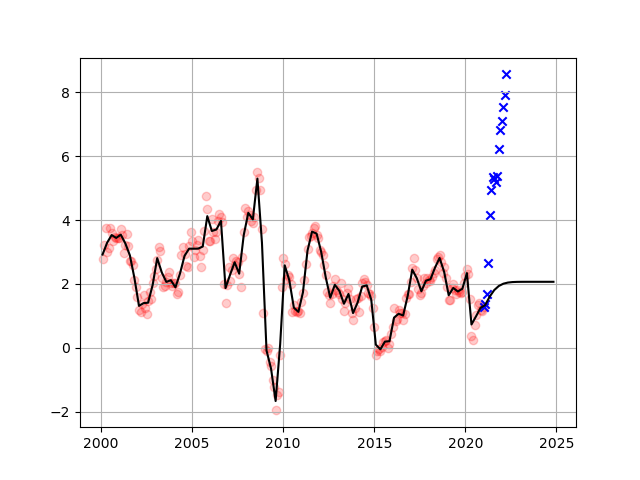

In [155]:
start_index = 0
fig, ax = plt.subplots();
ax.scatter(t.loc[start_date:end_date]+t_base_year,cpi_all_yoy.loc[start_date:end_date,country],c='r',marker='o', alpha=0.2);
ax.scatter(t.loc[end_date:]+t_base_year, cpi_all_yoy.loc[end_date:,country], color='b',marker='x');
ax.plot(X_predict[:,0]+t_base_year, y_predict[:,0], color='k');
ax.grid(True)

In [117]:
model.kernel_

1.19**2 + 0.252**2 * ExpSineSquared(length_scale=636, periodicity=0.284) + 1.31**2 * Matern(length_scale=0.459, nu=1.5) + DotProduct(sigma_0=2.3)